# Correcting vxy
removing problematic values before/after holes in time series

In [11]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
import dask.array as da

# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt
import hvplot.pandas
import holoviews as hv


import drifters.utils as ut
import pynsitu as pin

from dask.delayed import delayed

import GDP_lib as gdp

from GDP_lib import root_dir

In [12]:
from dask.distributed import Client

if True:
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client

    # cluster = PBSCluster()
    # w = cluster.scale(jobs=3) # 2 not enough for lon, lat, year, binning
    cluster = PBSCluster(cores=3, processes=3, walltime="04:00:00")
    w = cluster.scale(jobs=8)
else:
    from dask.distributed import LocalCluster

    cluster = LocalCluster()

client = Client(cluster)
client

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.216:53020/status,
Dashboard: http://10.148.0.216:53020/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.216:59713,Workers: 0
Dashboard: http://10.148.0.216:53020/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [13]:
parquet_argos = os.path.join(root_dir, "argos_av_time_corrected.parquet")
parquet_gps = os.path.join(root_dir, "gps_av_time_corrected.parquet")

In [14]:
df_gps = dd.read_parquet(parquet_gps).persist()
df_argos = dd.read_parquet(parquet_argos).persist()

In [15]:
df_gps

,id,lon,lat,ve,vn,typebuoy,gap,deploy_date,deploy_lat,deploy_lon,end_date,end_lat,end_lon,drogue_lost_date,typedeath,lon360,err_lat,err_lon,err_ve,err_vn,x,y,vex,vny,vxy,ae,an,aen,aex,any,axy,dt,vex_diff,vny_diff,vxy_diff
npartitions=181,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float32,float32,float32,float32,object,float64,datetime64[ns],float64,float64,datetime64[ns],float64,float64,datetime64[ns],float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [16]:
df_gps.columns

Index(['id', 'lon', 'lat', 've', 'vn', 'typebuoy', 'gap', 'deploy_date',
       'deploy_lat', 'deploy_lon', 'end_date', 'end_lat', 'end_lon',
       'drogue_lost_date', 'typedeath', 'lon360', 'err_lat', 'err_lon',
       'err_ve', 'err_vn', 'x', 'y', 'vex', 'vny', 'vxy', 'ae', 'an', 'aen',
       'aex', 'any', 'axy', 'dt', 'vex_diff', 'vny_diff', 'vxy_diff'],
      dtype='object')

_____
## Trajectories

In [17]:
list_id = list(df_gps.get_partition(0).compute().groupby("id").groups.keys())
_id = list_id[0]
grp_id = (
    df_gps.get_partition(0)
    .groupby("id")
    .get_group(_id)
    .rename(columns={"vex": "vex_geoid", "vny": "vny_geoid"})
    .compute()
)
grp_id.head()
# grp_idw = df_gw.get_partition(0).groupby('id').get_group(_id).set_index('time').rename(columns={'vex':'vex_diff', 'vny':'vny_diff'}).compute()

,id,lon,lat,ve,vn,typebuoy,gap,deploy_date,deploy_lat,deploy_lon,...,ae,an,aen,aex,any,axy,dt,vex_diff,vny_diff,vxy_diff
time,,,,,,,,,,,,,,,,,,,,,
2001-07-01 02:00:00,22192,-94.795609,5.53791,0.6460,-0.2900,SVPG,7171.0,2001-06-30,5.587,-94.915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.640586,-0.277083,0.697944
2001-07-01 03:00:00,22192,-94.774597,5.52852,0.6466,-0.2901,SVPG,7171.0,2001-06-30,5.587,-94.915,...,-2.777825e-07,-3.472219e-07,4.446641e-07,1.698938e-06,-3.157259e-06,3.585342e-06,3600.0,0.649776,-0.294098,0.713234
2001-07-01 04:00:00,22192,-94.753387,5.51876,0.6440,-0.2925,SVPG,37800.0,2001-06-30,5.587,-94.915,...,-1.361113e-06,-1.180553e-06,1.801759e-06,2.221023e-06,-5.036993e-06,5.504929e-06,3600.0,0.656843,-0.308824,0.725820
2001-07-01 05:00:00,22192,-94.731918,5.50841,0.6368,-0.2986,SVPG,37800.0,2001-06-30,5.587,-94.915,...,-2.000001e-06,-1.694444e-06,2.621287e-06,-6.206238e-08,8.546555e-08,1.056224e-07,3600.0,0.660741,-0.317713,0.733158
2001-07-01 06:00:00,22192,-94.710457,5.49807,0.6296,-0.3047,SVPG,37800.0,2001-06-30,5.587,-94.915,...,-2.000001e-06,-1.694444e-06,2.621287e-06,6.839744e-08,4.095455e-09,6.851994e-08,3600.0,0.660764,-0.317528,0.733098


In [18]:
hvplot = (
    grp_id["x"].hvplot(grid=True)
    + grp_id["y"].hvplot(grid=True)
    + grp_id["ve"].hvplot(grid=True)
    * grp_id["vex_geoid"].hvplot()
    * grp_id["vex_diff"].hvplot()
    + grp_id["vn"].hvplot(grid=True)
    * grp_id["vny_geoid"].hvplot(grid=True)
    * grp_id["vny_diff"].hvplot(grid=True)
    + grp_id["ae"].hvplot(grid=True) * grp_id["aex"].hvplot(grid=True)
    + grp_id["an"].hvplot(grid=True) * grp_id["any"].hvplot(grid=True)
)
layout = hv.Layout(hvplot).cols(2)

layout

:Layout
   .Curve.X     :Curve   [time]   (x)
   .Curve.Y     :Curve   [time]   (y)
   .Overlay.I   :Overlay
      .Curve.Ve        :Curve   [time]   (ve)
      .Curve.Vex_geoid :Curve   [time]   (vex_geoid)
      .Curve.Vex_diff  :Curve   [time]   (vex_diff)
   .Overlay.II  :Overlay
      .Curve.Vn        :Curve   [time]   (vn)
      .Curve.Vny_geoid :Curve   [time]   (vny_geoid)
      .Curve.Vny_diff  :Curve   [time]   (vny_diff)
   .Overlay.III :Overlay
      .Curve.Ae  :Curve   [time]   (ae)
      .Curve.Aex :Curve   [time]   (aex)
   .Overlay.IV  :Overlay
      .Curve.An  :Curve   [time]   (an)
      .Curve.Any :Curve   [time]   (any)

In [18]:
hvplot = (
    grp_id["x"].hvplot(grid=True)
    + grp_id["y"].hvplot(grid=True)
    + grp_id["ve"].hvplot(grid=True)
    * grp_id["vex_geoid"].hvplot()
    * grp_id["vex_diff"].hvplot()
    + grp_id["vn"].hvplot(grid=True)
    * grp_id["vny_geoid"].hvplot(grid=True)
    * grp_id["vny_diff"].hvplot(grid=True)
    + grp_id["ae"].hvplot(grid=True) * grp_id["aex"].hvplot(grid=True)
    + grp_id["an"].hvplot(grid=True) * grp_id["any"].hvplot(grid=True)
)
layout = hv.Layout(hvplot).cols(2)

layout

:Layout
   .Curve.X     :Curve   [time]   (x)
   .Curve.Y     :Curve   [time]   (y)
   .Overlay.I   :Overlay
      .Curve.Ve        :Curve   [time]   (ve)
      .Curve.Vex_geoid :Curve   [time]   (vex_geoid)
      .Curve.Vex_diff  :Curve   [time]   (vex_diff)
   .Overlay.II  :Overlay
      .Curve.Vn        :Curve   [time]   (vn)
      .Curve.Vny_geoid :Curve   [time]   (vny_geoid)
      .Curve.Vny_diff  :Curve   [time]   (vny_diff)
   .Overlay.III :Overlay
      .Curve.Ae  :Curve   [time]   (ae)
      .Curve.Aex :Curve   [time]   (aex)
   .Overlay.IV  :Overlay
      .Curve.An  :Curve   [time]   (an)
      .Curve.Any :Curve   [time]   (any)

_____
## Energies per drifters


In [19]:
df_gps["ve2"] = df_gps.ve**2
df_gps["vn2"] = df_gps.vn**2
df_gps["vex2"] = df_gps.vex**2
df_gps["vny2"] = df_gps.vny**2

__________
## Global mean/variance/std 
- no significative difference between ven (Elipot computation) and vxy (differenciation)
- difference between aen (Elipot computation differentiation) and axy (differenciation) -> difference centered or double differenciation methods ?

In [20]:
def print_mean_var(df):
    for l in df.columns:
        print(
            l
            + f": mean = {df[l].mean().compute()}, variance = {df[l].var().compute()}, std = {df[l].std().compute()}"
        )

In [ ]:
print_mean_var(df_gps[["ve", "vn", "ae", "an", "vex", "vny", "aex", "any"]])

ve: mean = 0.01179404270746986, variance = 0.06284323334693909, std = 0.25068551301956177
vn: mean = 0.003311353219497805, variance = 0.04800022020936012, std = 0.21908952295780182
ae: mean = -2.145224595008539e-10, variance = 1.428459739315542e-10, std = 1.1951818854532318e-05
an: mean = -6.527747827486453e-10, variance = 1.4388561946666652e-10, std = 1.199523319767759e-05
vex: mean = 0.012025497806043475, variance = 0.06268615804451004, std = 0.25037203926259427
vny: mean = 0.0033138106352054043, variance = 0.04739639913187437, std = 0.2177071407461739
aex: mean = -2.491858589539016e-10, variance = 3.603869997260408e-10, std = 1.898386155991559e-05
any: mean = -2.535668160324777e-09, variance = 3.875785911632492e-10, std = 1.9687015801366373e-05


In [22]:
print_mean_var(df_argos[["ve", "vn", "ae", "an", "vex", "vny", "aex", "any"]])

ve: mean = 0.005583182291101385, variance = 0.07471064478158951, std = 0.27333247661590576
vn: mean = 0.005280918545608172, variance = 0.0525890477001667, std = 0.22932301461696625
ae: mean = -3.146769923988487e-10, variance = 3.044508021651437e-10, std = 1.7448518623801385e-05
an: mean = 9.626259155359507e-11, variance = 2.3228301525679198e-10, std = 1.524083381107451e-05
vex: mean = 0.0054706001293681784, variance = 0.0756049675815794, std = 0.2749635750087262
vny: mean = 0.005269581897011892, variance = 0.05279445610788963, std = 0.2297704421980548
aex: mean = -6.768860657919765e-10, variance = 2.4018920137476496e-09, std = 4.900910133585036e-05
any: mean = 3.329176022489228e-10, variance = 1.4514034327334328e-09, std = 3.809728904703631e-05


In [24]:
listv = ["ve", "vex", "vex_diff", "vn", "vny", "vny_diff"]
lista = ["ae", "aex", "an", "any"]


def list_std(df, listv_=listv, lista_=lista):
    stdv = []
    for l in listv_:
        stdv.append(df[l].std().compute())
    stda = []
    for l in lista_:
        stda.append(df[l].std().compute())
    return np.array(stdv), np.array(stda)


stdv_a, stda_a = list_std(df_argos)
stdv_g, stda_g = list_std(df_gps)

In [26]:
stdv_a**2

array([0.07471064, 0.07568924, 0.07621974, 0.05258905, 0.05311539,
       0.06225505])

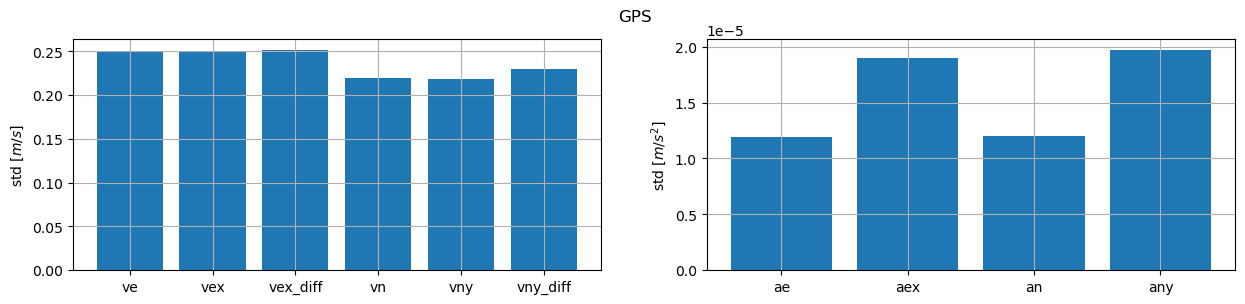

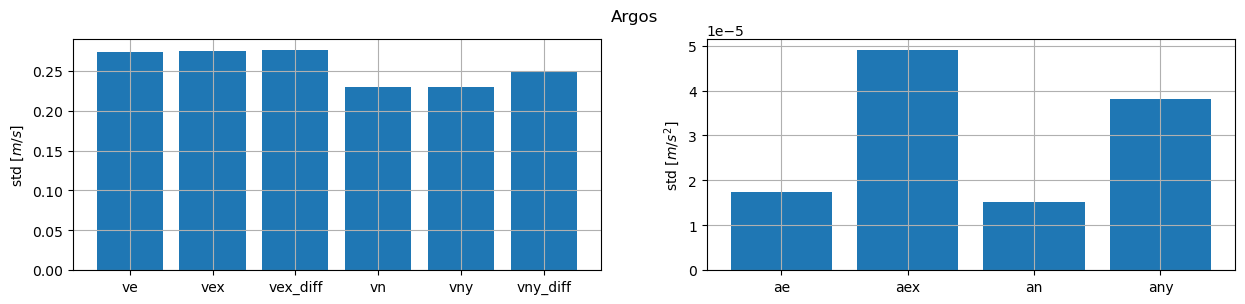

In [25]:
def print_std(listv, stdv, lista, stda, title):
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    axs = axs.flatten()
    axs[0].grid()
    axs[1].grid()
    axs[0].bar(listv, stdv)
    axs[1].bar(lista, stda)
    axs[0].set_ylabel(r"std $[m/s]$")
    axs[1].set_ylabel(r"std $[m/s^2]$")
    fig.suptitle(title)


print_std(listv, stdv_g, lista, stda_g, "GPS")
print_std(listv, stdv_a, lista, stda_a, "Argos")

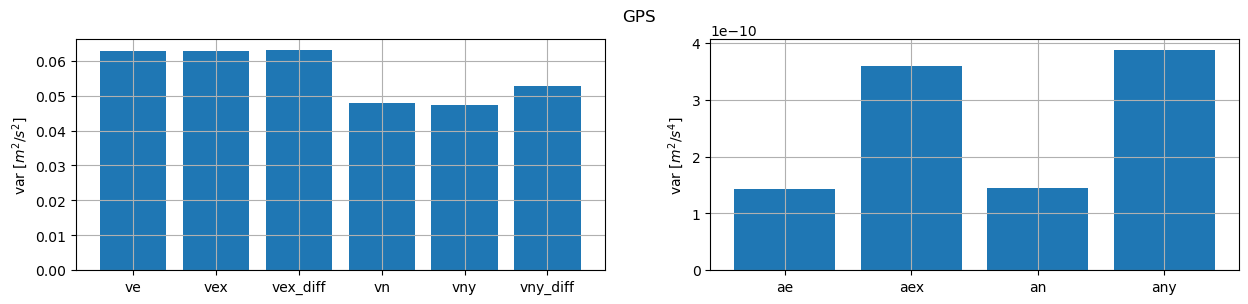

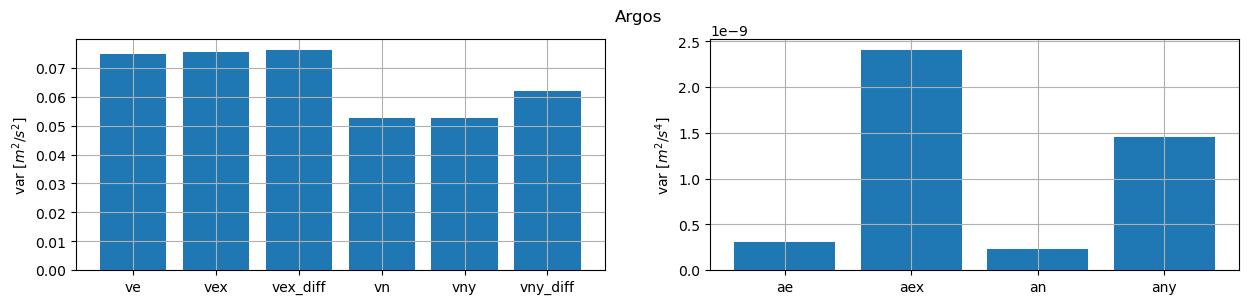

In [26]:
def print_var(listv, stdv, lista, stda, title):
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    axs = axs.flatten()
    axs[0].grid()
    axs[1].grid()
    axs[0].bar(listv, stdv**2)
    axs[1].bar(lista, stda**2)
    axs[0].set_ylabel(r"var $[m^2/s^2]$")
    axs[1].set_ylabel(r"var $[m^2/s^4]$")
    fig.suptitle(title)


print_var(listv, stdv_g, lista, stda_g, "GPS")
print_var(listv, stdv_a, lista, stda_a, "Argos")

- $a_{e,n}$ are computed from ve,n by a centered differenciation :
$$ \langle a^2_{e,n} \rangle = \frac{\langle v_{e,n}^2 \rangle - C_u(2dt)}{2dt^2}$$
- $a_{x,y}$ are computed from x,y by two simple differenciations :
$$ \langle a^2_{x,y} \rangle = 2\frac{\langle v_{x,y}^2 \rangle - C_u(dt)}{dt^2}$$

This might explain the observed difference

______________
## Dependence on x,y
- no significative trend

In [27]:
def add_diff_va(df):
    df["ae-aex"] = df["ae"] - df["aex"]
    df["an-any"] = df["an"] - df["any"]
    df["ve-vex"] = df["ve"] - df["vex"]
    df["vn-vny"] = df["vn"] - df["vny"]
    df["ae-aex/ae"] = df["ae-aex"] / df["ae"]
    df["an-any/an"] = df["an-any"] / df["an"]
    df["ve-vex/ve"] = df["ve-vex"] / df["ve"]
    df["vn-vny/vn"] = df["vn-vny"] / df["vn"]


add_diff_va(df_gps)
add_diff_va(df_argos)

In [28]:
def deriv_dep2_x(df):
    xmin = (df["x"].min()).compute()
    xmax = (df["x"].max()).compute()

    # delta_gap = (gap_min - t_start)/pd.Timedelta('1H')
    xbins = np.arange(xmin, xmax, 500)  # 10min binning
    df["xcut"] = df["x"].map_partitions(pd.cut, xbins)
    mean = (
        df[
            [
                "ae-aex",
                "an-any",
                "ve-vex",
                "vn-vny",
                "ae-aex/ae",
                "an-any/an",
                "ve-vex/ve",
                "vn-vny/vn",
            ]
        ]
        .groupby(df.xcut)
        .mean()
        .compute()
        .rename(
            columns={
                l: "mean_" + l
                for l in [
                    "ae-aex",
                    "an-any",
                    "ve-vex",
                    "vn-vny",
                    "ae-aex/ae",
                    "an-any/an",
                    "ve-vex/ve",
                    "vn-vny/vn",
                ]
            }
        )
        # .to_frame() ALREADY A DATAFRAME
    )
    mean["x"] = mean.index.to_series().apply(lambda d: d.mid)
    mean = mean.set_index("x")

    ds = (
        mean
        # .drop(columns=["year",])
        .to_xarray()
    )
    return ds

In [29]:
def deriv_dep2_y(df):
    xmin = (df["y"].min()).compute()
    xmax = (df["y"].max()).compute()

    # delta_gap = (gap_min - t_start)/pd.Timedelta('1H')
    xbins = np.arange(xmin, xmax, 500)  # 10min binning
    df["ycut"] = df["y"].map_partitions(pd.cut, xbins)
    mean = (
        df[
            [
                "ae-aex",
                "an-any",
                "ve-vex",
                "vn-vny",
                "ae-aex/ae",
                "an-any/an",
                "ve-vex/ve",
                "vn-vny/vn",
            ]
        ]
        .groupby(df.ycut)
        .mean()
        .compute()
        .rename(
            columns={
                l: "mean_" + l
                for l in [
                    "ae-aex",
                    "an-any",
                    "ve-vex",
                    "vn-vny",
                    "ae-aex/ae",
                    "an-any/an",
                    "ve-vex/ve",
                    "vn-vny/vn",
                ]
            }
        )
        # .to_frame() ALREADY A DATAFRAME
    )
    mean["y"] = mean.index.to_series().apply(lambda d: d.mid)
    mean = mean.set_index("y")

    ds = (
        mean
        # .drop(columns=["year",])
        .to_xarray()
    )
    return ds

In [30]:
ds_x_gps = deriv_dep2_x(df_gps)
ds_y_gps = deriv_dep2_y(df_gps)

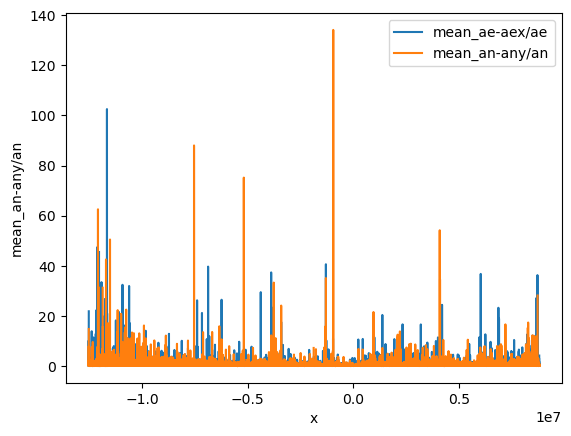

In [31]:
abs(ds_x_gps["mean_ae-aex/ae"]).plot(label="mean_ae-aex/ae")
abs(ds_x_gps["mean_an-any/an"]).plot(label="mean_an-any/an")
plt.legend()

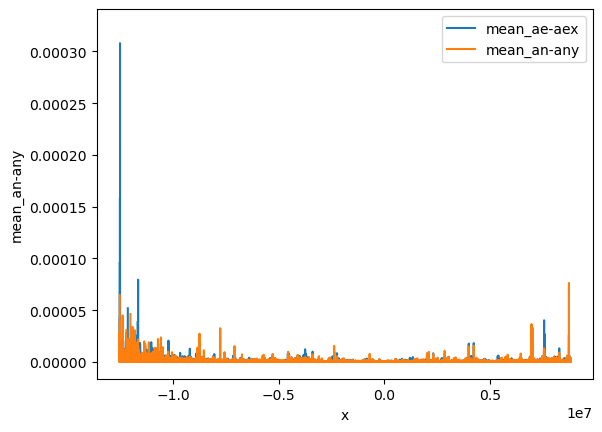

In [32]:
abs(ds_x_gps["mean_ae-aex"]).plot(label="mean_ae-aex")
abs(ds_x_gps["mean_an-any"]).plot(label="mean_an-any")
plt.legend()

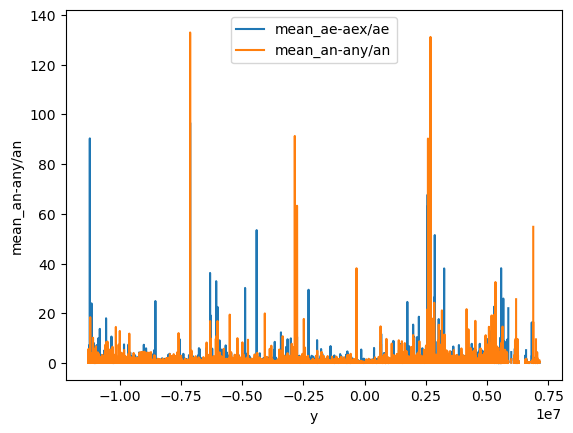

In [33]:
abs(ds_y_gps["mean_ae-aex/ae"]).plot(label="mean_ae-aex/ae")
abs(ds_y_gps["mean_an-any/an"]).plot(label="mean_an-any/an")
plt.legend()

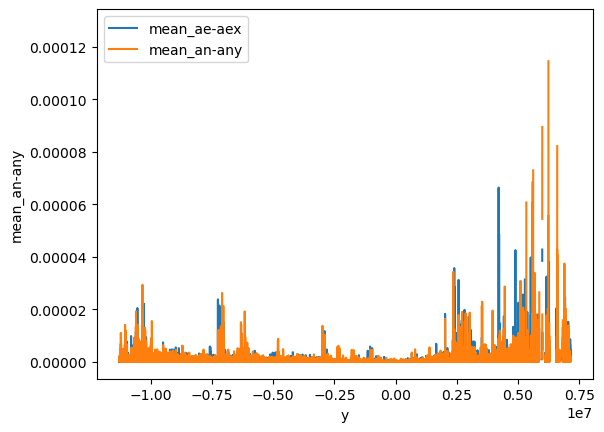

In [34]:
abs(ds_y_gps["mean_ae-aex"]).plot(label="mean_ae-aex")
abs(ds_y_gps["mean_an-any"]).plot(label="mean_an-any")
plt.legend()

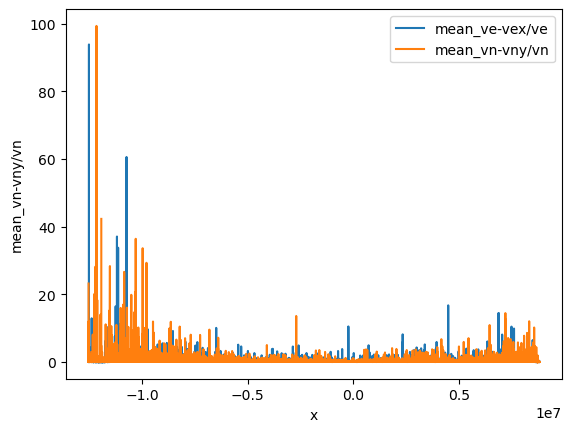

In [35]:
abs(ds_x_gps["mean_ve-vex/ve"]).plot(label="mean_ve-vex/ve")
abs(ds_x_gps["mean_vn-vny/vn"]).plot(label="mean_vn-vny/vn")
plt.legend()

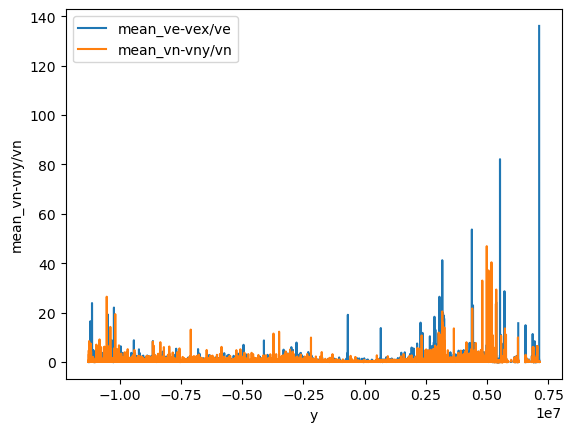

In [36]:
abs(ds_y_gps["mean_ve-vex/ve"]).plot(label="mean_ve-vex/ve")
abs(ds_y_gps["mean_vn-vny/vn"]).plot(label="mean_vn-vny/vn")
plt.legend()

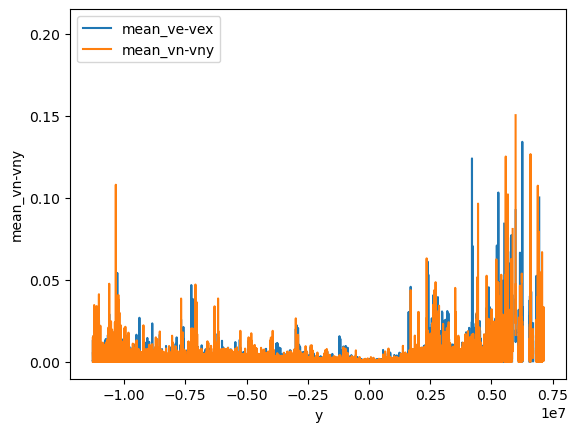

In [37]:
abs(ds_y_gps["mean_ve-vex"]).plot(label="mean_ve-vex")
abs(ds_y_gps["mean_vn-vny"]).plot(label="mean_vn-vny")
plt.legend()

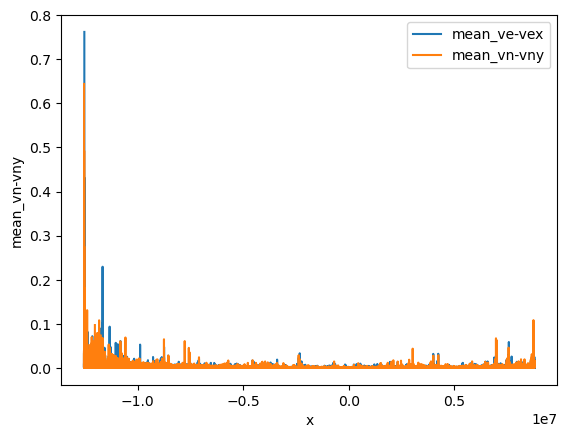

In [38]:
abs(ds_x_gps["mean_ve-vex"]).plot(label="mean_ve-vex")
abs(ds_x_gps["mean_vn-vny"]).plot(label="mean_vn-vny")
plt.legend()

___
## Dependence on the gap
- difference seem to depend on the gap 

In [39]:
def deriv_dep2_gap(df):
    gap_min = (df["gap"].min()).compute()
    gap_max = (df["gap"].max()).compute()

    # delta_gap = (gap_min - t_start)/pd.Timedelta('1H')
    gap_bins = np.arange(gap_min, gap_max, 1800)  # 10min binning
    df["gap_cut"] = df["gap"].map_partitions(pd.cut, gap_bins)
    mean_gap = (
        df[["ae-aex/ae", "an-any/an", "ve-vex/ve", "vn-vny/vn"]]
        .groupby(df.gap_cut)
        .mean()
        .compute()
        .rename(
            columns={
                l: "mean_" + l
                for l in ["ae-aex/ae", "an-any/an", "ve-vex/ve", "vn-vny/vn"]
            }
        )
        # .to_frame() ALREADY A DATAFRAME
    )
    mean_gap["gap"] = mean_gap.index.to_series().apply(lambda d: d.mid)
    mean_gap = mean_gap.set_index("gap")

    ds = (
        mean_gap
        # .drop(columns=["year",])
        .to_xarray()
    )
    ds["gap"] = ds["gap"] / 3600  # gap in hours
    return ds

In [40]:
ds_gap_gps = deriv_dep2_gap(df_gps)

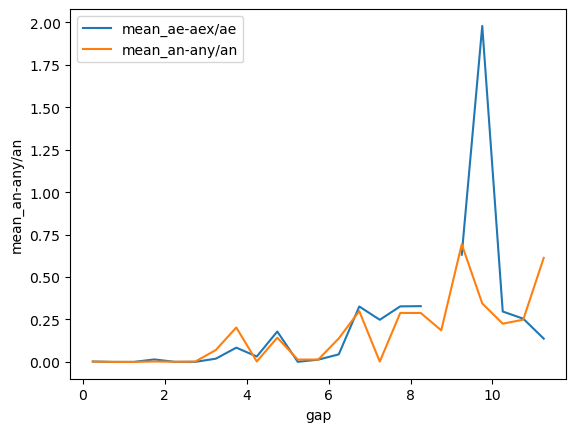

In [41]:
abs(ds_gap_gps["mean_ae-aex/ae"]).plot(label="mean_ae-aex/ae")
abs(ds_gap_gps["mean_an-any/an"]).plot(label="mean_an-any/an")
plt.legend()

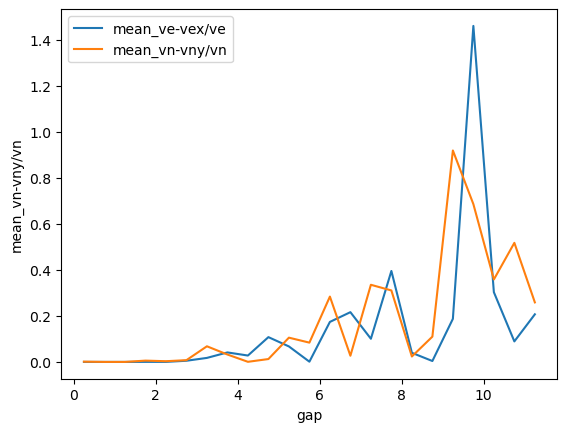

In [42]:
abs(ds_gap_gps["mean_ve-vex/ve"]).plot(label="mean_ve-vex/ve")
abs(ds_gap_gps["mean_vn-vny/vn"]).plot(label="mean_vn-vny/vn")
plt.legend()

In [43]:
cluster.close()

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min